<a href="https://colab.research.google.com/github/alawrence30/Deep-Learning/blob/main/11_12_Assignment_4_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#https://www.kaggle.com/code/tilasousa/face-mask-detection-using-keras-cnn

# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import cv2
from scipy.spatial import distance
import glob
from warnings import filterwarnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model, load_model
from sklearn.metrics import classification_report , confusion_matrix
from skimage import io
filterwarnings("ignore")

from keras_preprocessing.image import img_to_array
from keras_preprocessing.image import load_img


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow_datasets as tfds
from keras import callbacks
from sklearn.metrics import accuracy_score
from os import listdir
from os.path import isfile, join

In [3]:
## Accuracy and Loss Graph
def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

## Validation Report
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 

## Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

# defining callback function to avoid overfit
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 6, 
                                        restore_best_weights = True, verbose=1)

# EDA

The path is created for getting data and then I concatened dataframes of mask and without mask.

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
path  = '/content/gdrive/My Drive/MSDS 458/Assignment 4 - Final/Data/Face Mask Dataset/'

In [6]:
# train dataset
train_dir = os.path.join(path, 'Train')

train_ds = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            batch_size=32,
                                                            image_size=(256,256),
                                                            shuffle=True)

Found 10000 files belonging to 2 classes.


In [7]:
# validation dataset
validation_dir = os.path.join(path, 'Validation')

validation_ds = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                            batch_size=32,
                                                            image_size=(256,256),
                                                            shuffle=True)

Found 800 files belonging to 2 classes.


In [8]:
# test dataset
test_dir = os.path.join(path, 'Test')

test_ds = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                            batch_size=32,
                                                            image_size=(256,256),
                                                            shuffle=True)

Found 992 files belonging to 2 classes.


In [9]:
class_names = train_ds.class_names
print(class_names)

['WithMask', 'WithoutMask']


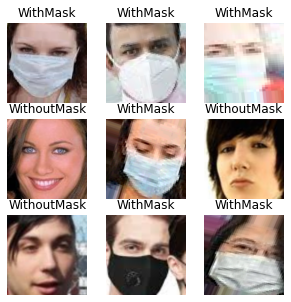

In [10]:
plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
# autotune buffer to avoid I/0 block
autotune = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=autotune)
validation_ds = validation_ds.cache().prefetch(buffer_size=autotune)

# Model 11

CNN

Input layer

Convolutional layer 1: 16 units, Relu activation - Maxpool Layer

Convolutional layer 2: 32 units, Relu activation - Maxpool Layer

Convolutional layer 3: 96 units Relu activation - Maxpool Layer 

Convolutional layer 4: 128 units, Relu activation - Maxpool Layer

Hidden Layer 1: 164 units, Relu Activation

Output layer: Dense 2 units, softmax activation


In [14]:
num_classes = 2

model11 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
  tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
  tf.keras.layers.Conv2D(96, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
  tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(164, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

model11.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

In [15]:
history11 = model11.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=41,
  callbacks =[earlystopping]
)

Epoch 1/41
313/313 [==============================] - 862s 3s/step - loss: 0.1667 - accuracy: 0.9334 - val_loss: 0.0343 - val_accuracy: 0.9900
Epoch 2/41
313/313 [==============================] - 15s 49ms/step - loss: 0.0498 - accuracy: 0.9814 - val_loss: 0.0251 - val_accuracy: 0.9912
Epoch 3/41
313/313 [==============================] - 15s 49ms/step - loss: 0.0383 - accuracy: 0.9871 - val_loss: 0.0250 - val_accuracy: 0.9900
Epoch 4/41
313/313 [==============================] - 15s 49ms/step - loss: 0.0276 - accuracy: 0.9908 - val_loss: 0.0213 - val_accuracy: 0.9925
Epoch 5/41
313/313 [==============================] - 15s 48ms/step - loss: 0.0282 - accuracy: 0.9902 - val_loss: 0.0338 - val_accuracy: 0.9887
Epoch 6/41
313/313 [==============================] - 15s 48ms/step - loss: 0.0189 - accuracy: 0.9940 - val_loss: 0.0210 - val_accuracy: 0.9900
Epoch 7/41
313/313 [==============================] - 15s 49ms/step - loss: 0.0153 - accuracy: 0.9946 - val_loss: 0.0287 - val_accuracy: 

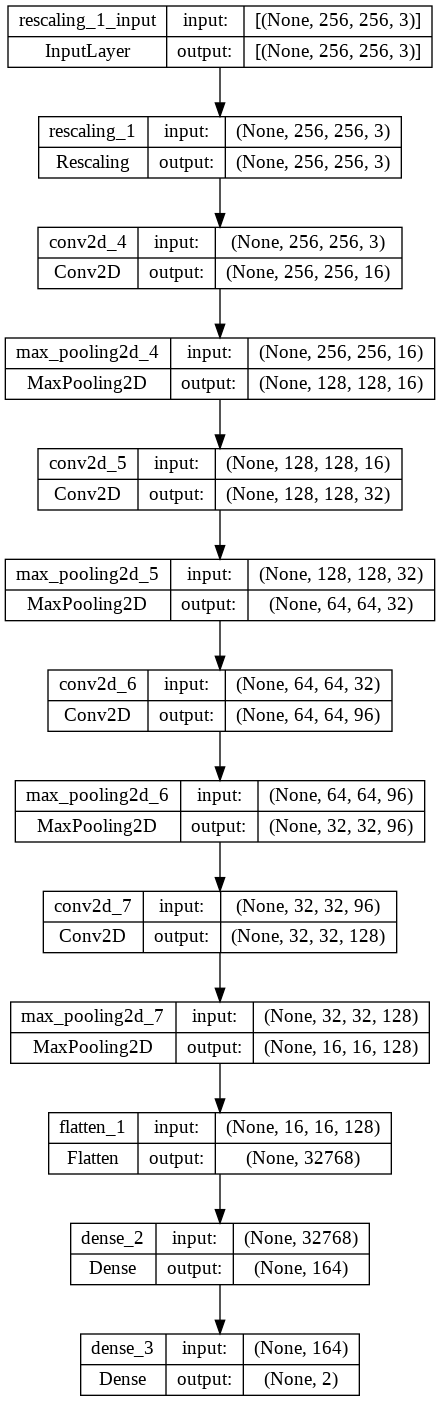

In [16]:
keras.utils.plot_model(model11, "model11.png", show_shapes=True) 

## Evaluate

In [17]:
history_dict11 = history11.history
history_dict11.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [18]:
history_df11 = pd.DataFrame(history_dict11)
history_df11.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
7,0.020,0.993,0.038,0.989
8,0.010,0.997,0.025,0.993
9,0.009,0.997,0.027,0.993
10,0.014,0.994,0.028,0.993
11,0.014,0.995,0.022,0.994


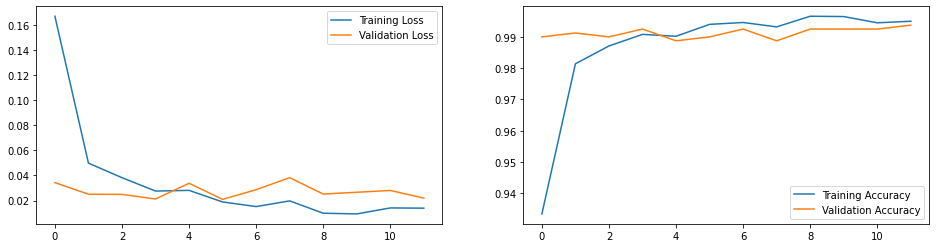

In [19]:
## Loss and acuracy
plot_history(history11)

In [20]:
test_pred11 = model11.predict(test_ds)
test_pred11 = np.argmax(test_pred11,axis = 1)
test_labels11 = np.concatenate([y for x, y in test_ds], axis=0)

31/31 [==============================] - 105s 2s/step


Text(0.5, 1.0, 'Confusion Matrix - Test Set')

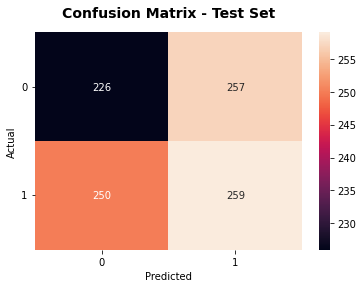

In [21]:
plt.figure(figsize=(6, 4))
ax = sns.heatmap(tf.math.confusion_matrix(
    test_labels11,
    test_pred11,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
),annot = True,
  fmt="d")
ax.set_xlabel('Predicted',fontsize = 10)
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 10) 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 14,weight = 'bold',pad=15)

In [22]:
# 0 = without mask, 1 = with mask
# 992 images in test set, model missed 250 with mask and 257 without mask

In [23]:
import numpy
from sklearn import metrics

actual11 = test_labels11
predicted11 = test_pred11

Accuracy = metrics.accuracy_score(actual11, predicted11)
Precision = metrics.precision_score(actual11, predicted11)
Sensitivity_recall = metrics.recall_score(actual11, predicted11)
Specificity = metrics.recall_score(actual11, predicted11, pos_label=0)
F1_score = metrics.f1_score(actual11, predicted11)

#metrics:
print({"Accuracy":Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity,"F1_score":F1_score})

{'Accuracy': 0.4889112903225806, 'Precision': 0.501937984496124, 'Sensitivity_recall': 0.5088408644400786, 'Specificity': 0.46790890269151136, 'F1_score': 0.5053658536585366}


In [24]:
# report
labels = ['withMask', 'withoutMask']
print(classification_report(actual11, predicted11, target_names = labels))

              precision    recall  f1-score   support

    withMask       0.47      0.47      0.47       483
 withoutMask       0.50      0.51      0.51       509

    accuracy                           0.49       992
   macro avg       0.49      0.49      0.49       992
weighted avg       0.49      0.49      0.49       992



# Model 12

CNN

Input layer

Convolutional layer 3: 128 units Relu activation 

Maxpool Layer 32x32

Convolutional layer 4: 256 units, Relu activation 

Maxpool Layer 16x16

Hidden Layer 1: 256 units, Relu Activation

Output layer: Dense 2 units, sigmoid activation


In [27]:
num_classes = 2

model12 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
  tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(num_classes, activation='sigmoid')
])

model12.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

In [28]:
history12 = model12.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=41,
  callbacks =[earlystopping]
)

Epoch 1/41
313/313 [==============================] - 67s 211ms/step - loss: 0.9961 - accuracy: 0.9371 - val_loss: 0.0744 - val_accuracy: 0.9750
Epoch 2/41
313/313 [==============================] - 64s 204ms/step - loss: 0.0501 - accuracy: 0.9822 - val_loss: 0.0463 - val_accuracy: 0.9887
Epoch 3/41
313/313 [==============================] - 63s 203ms/step - loss: 0.0384 - accuracy: 0.9865 - val_loss: 0.0233 - val_accuracy: 0.9950
Epoch 4/41
313/313 [==============================] - 64s 204ms/step - loss: 0.0253 - accuracy: 0.9916 - val_loss: 0.0193 - val_accuracy: 0.9937
Epoch 5/41
313/313 [==============================] - 63s 201ms/step - loss: 0.0102 - accuracy: 0.9964 - val_loss: 0.0206 - val_accuracy: 0.9900
Epoch 6/41
313/313 [==============================] - 63s 201ms/step - loss: 0.0088 - accuracy: 0.9974 - val_loss: 0.0282 - val_accuracy: 0.9875
Epoch 7/41
313/313 [==============================] - 63s 201ms/step - loss: 0.0264 - accuracy: 0.9919 - val_loss: 0.0463 - val_ac

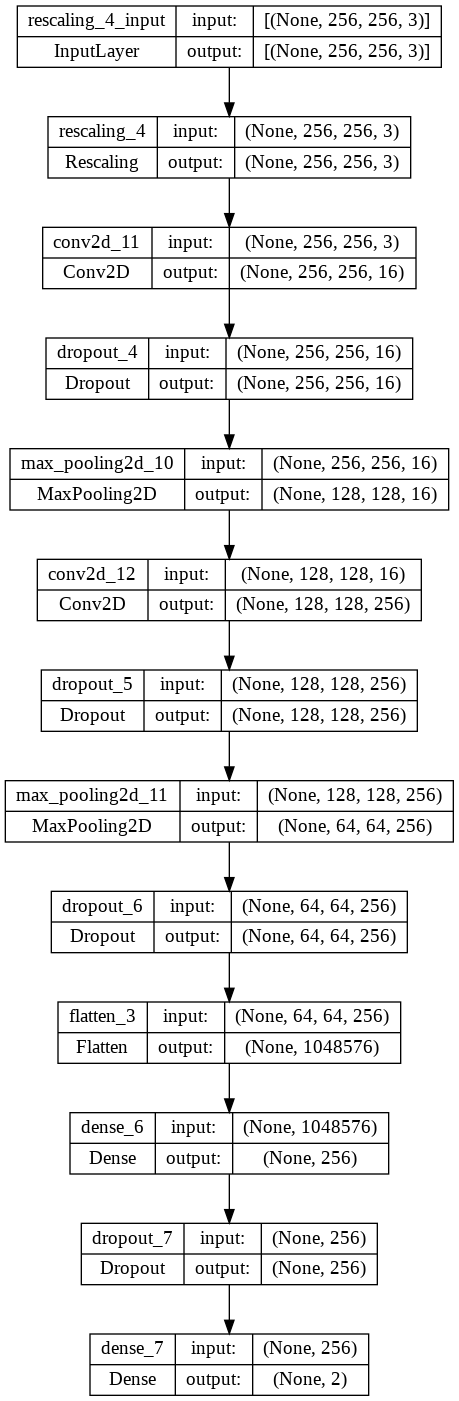

In [29]:
keras.utils.plot_model(model12, "model12.png", show_shapes=True) 

## Evaluate

In [30]:
history_dict12 = history12.history
history_dict12.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [31]:
history_df12=pd.DataFrame(history_dict12)
history_df12.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
5,0.009,0.997,0.028,0.988
6,0.026,0.992,0.046,0.983
7,0.036,0.989,0.030,0.990
8,0.012,0.996,0.146,0.967
9,0.015,0.994,0.033,0.990


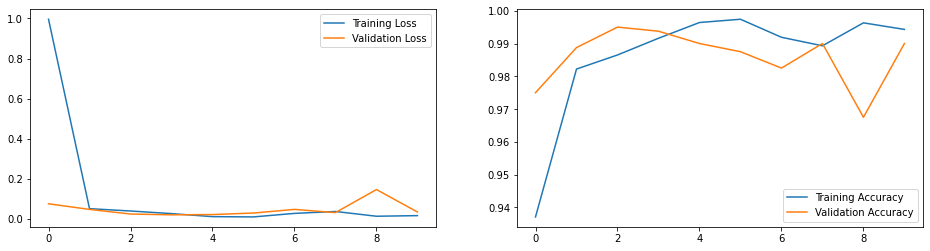

In [32]:
## Loss and acuracy
plot_history(history12)

In [33]:
test_pred12 = model12.predict(test_ds)
test_pred12 = np.argmax(test_pred12,axis = 1)
test_labels12 = np.concatenate([y for x, y in test_ds], axis=0)

31/31 [==============================] - 2s 55ms/step


Text(0.5, 1.0, 'Confusion Matrix - Test Set')

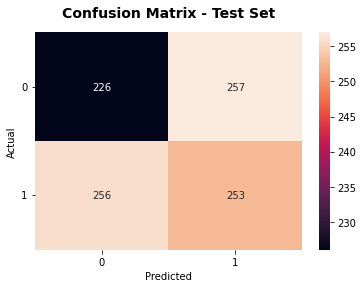

In [34]:
plt.figure(figsize=(6, 4))
ax = sns.heatmap(tf.math.confusion_matrix(
    test_labels12,
    test_pred12,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
),annot = True,
  fmt="d")
ax.set_xlabel('Predicted',fontsize = 10)
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 10) 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 14,weight = 'bold',pad=15)

In [35]:
# 0 = without mask, 1 = with mask
# 992 images in test set, model missed 251 with mask and 249 without mask

In [36]:
actual12 = test_labels12
predicted12 = test_pred12

Accuracy = metrics.accuracy_score(actual12, predicted12)
Precision = metrics.precision_score(actual12, predicted12)
Sensitivity_recall = metrics.recall_score(actual12, predicted12)
Specificity = metrics.recall_score(actual12, predicted12, pos_label=0)
F1_score = metrics.f1_score(actual12, predicted12)

#metrics:
print({"Accuracy":Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity,"F1_score":F1_score})

{'Accuracy': 0.48286290322580644, 'Precision': 0.49607843137254903, 'Sensitivity_recall': 0.49705304518664045, 'Specificity': 0.46790890269151136, 'F1_score': 0.4965652600588813}


In [37]:
# report
labels = ['withMask', 'withoutMask']
print(classification_report(actual12, predicted12, target_names = labels))

              precision    recall  f1-score   support

    withMask       0.47      0.47      0.47       483
 withoutMask       0.50      0.50      0.50       509

    accuracy                           0.48       992
   macro avg       0.48      0.48      0.48       992
weighted avg       0.48      0.48      0.48       992

